# Academy: Practicum Visualizing Galactic Chemical Evolution, Birth Radius, and Exoplanets

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
FIG_DIR = topic_root / "figures" / "en"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None, dpi: int = 200):
    """
    Save a matplotlib figure as PNG into FIG_DIR.
    Usage:
      - save_fig("Figure_1")            # saves current active figure
      - save_fig("Figure_1", fig=fig)   # saves explicit figure (recommended)
    """
    if not name.lower().endswith(".png"):
        name += ".png"

    if fig is None:
        fig = plt.gcf()  # get current figure

    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight", facecolor="white")
    print("Saved:", out, "| size:", out.stat().st_size, "bytes")

print("FIG_DIR:", FIG_DIR)

FIG_DIR: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en


## 1. Goal of the practicum
The goal of this practicum is to learn how to visually connect:
- Galactic Chemical Evolution (GCE),
- stellar birth radius (r₍birth₎),
- stellar migration,
and the observed distribution of exoplanets.

By the end of the practicum, we will have a set of plots that:
- explain both scientific papers,
- can be interpreted intuitively, without equations,
- can be directly reused in the Academy, Celestial Chronicles, and Astro Minute formats.

# Figure 1. Distribution of host stars by effective temperature for both data samples

## Purpose of the figure

This figure is constructed to compare the effective temperature ($T_{\mathrm{eff}}$) distributions of planet-hosting stars drawn from two independent samples: SWEET-Cat and HARPS-GTO. The goal is to assess whether both datasets probe comparable stellar populations in terms of spectral type and evolutionary stage, which is a necessary prerequisite for any meaningful comparative analysis of planetary properties and Galactic trends.

## Data used

Data used

For both samples, we use spectroscopically derived stellar effective temperatures provided in homogeneous form within each catalogue. In the case of SWEET-Cat, only stars with consistent spectroscopic parameters $(SWFlag = 1)$ are considered. For HARPS-GTO, the temperatures are taken directly from the published stellar parameter tables, distinguishing between planet-hosting stars and stars without detected planets.

## Method

The figure is constructed by plotting normalized histograms of $T_{\mathrm{eff}}$ for the two datasets. No evolutionary model assumptions are involved at this stage; the plot relies solely on directly observed stellar parameters. The same temperature range and binning scheme are applied to both samples to allow a direct visual comparison.




## Code explanation

What this code does

### 1) Imports and helper functions
The code starts by importing standard libraries for data handling (pandas), plotting (matplotlib), and online catalogue access (astroquery.vizier). Two small helper functions are defined:
	•	canon_name() standardizes stellar names into a canonical form, allowing robust cross-matching between different catalogues despite differences in formatting or notation.
	•	pick_col() selects the appropriate column containing host star names in the NEA table, accounting for variations in column naming between different data releases.

### 2) Project root detection and data paths
The script automatically locates the project root directory by searching for the topics/ folder and constructs relative paths to all required data files. This avoids hard-coded absolute paths and ensures portability across different systems.

### 3) Loading and preparing the SWEET-Cat sample (left panel)
The SWEET-Cat catalogue is loaded from a local CSV file. Only stars with homogeneous spectroscopic parameters (SWFlag == 1) are selected. The analysis is restricted to the effective temperature (Teff) and surface gravity (Logg), with rows containing missing or non-physical values removed. This produces a clean sample of planet-hosting stars for the left panel of the figure.

### 4) Loading and preparing the HARPS-GTO sample from Vizier (right panel)
The HARPS-GTO stellar sample is retrieved directly from the Vizier service using the published catalogue identifier. As for SWEET-Cat, stars with missing or non-physical values of Teff and logg are excluded.

### 5) Identifying host and single stars in HARPS-GTO
To distinguish between stars with and without detected planets in the HARPS-GTO sample, the NASA Exoplanet Archive (NEA) is used as a reference list of known planet hosts. Stellar names from HARPS-GTO are canonicalized and cross-matched against NEA host names. Stars with a match are classified as planet hosts, while the remainder are treated as single stars.

### 6) Construction and export of Figure 1
The final figure consists of two scatter plots:
	•	the left panel shows SWEET-Cat host stars (blue points);
	•	the right panel shows HARPS-GTO stars, with single stars in green and planet-hosting stars in orange.

Both axes are inverted to follow the conventional presentation of Kiel (log g–T_{\rm eff}) diagrams. The figure is then saved as Figure_1.png using the standardized save_fig() helper, making it available for inclusion in other notebooks and documents.


SWEET: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw/sweetcat.csv exists: True
NEA:   /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw/nea_ps_default_flag_1.csv exists: True
NEA host column: hostname unique hosts: 4524
HARPS total: 1111 hosts: 170 single: 941
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_1.png | size: 279382 bytes


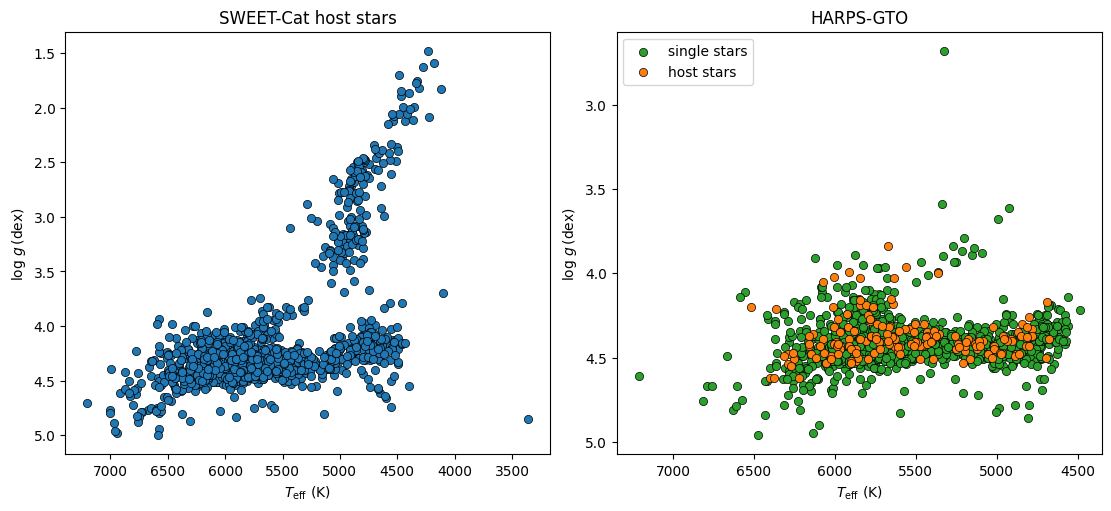

In [4]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from lulab.anim.defaults import apply_theme, save_animation, THEME
from lulab.anim.plot_helpers import make_fig, set_common_axes

# ---------- helpers ----------
def canon_name(x: str) -> str:
    """Canonicalize star/host names for loose matching."""
    if pd.isna(x):
        return ""
    s = str(x).strip().lower()
    s = s.replace("–", "-").replace("—", "-")
    s = re.sub(r"\(.*?\)", "", s)          # remove parenthetical
    s = re.sub(r"\s+", " ", s)             # normalize whitespace
    s = re.sub(r"[^a-z0-9+\- ]", "", s)    # keep basic chars
    s = s.replace(" ", "")                 # remove spaces (important for 'hd 1234')
    return s

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# ---------- paths (project root search) ----------
cwd = Path.cwd()
project_root = None
for parent in [cwd] + list(cwd.parents):
    if (parent / "topics").exists():
        project_root = parent
        break
if project_root is None:
    raise RuntimeError("Project root not found (folder 'topics' not found).")

topic_root = project_root / "topics/TOP_0001_exoplanet_birth_radius"
sweet_path = topic_root / "data/raw/sweetcat.csv"
nea_path   = topic_root / "data/raw/nea_ps_default_flag_1.csv"

print("SWEET:", sweet_path, "exists:", sweet_path.exists())
print("NEA:  ", nea_path,   "exists:", nea_path.exists())

# ---------- load SWEET-Cat (left panel) ----------
sweet = pd.read_csv(sweet_path)
sweet_df = sweet[sweet["SWFlag"] == 1].copy()
sweet_df = sweet_df[["Teff", "Logg"]].dropna()
sweet_df = sweet_df[(sweet_df["Teff"] > 0) & (sweet_df["Logg"] > 0)]

# ---------- load HARPS-GTO from Vizier ----------
Vizier.ROW_LIMIT = -1
tabs = Vizier.get_catalogs("J/A+A/545/A32")
harps = tabs[0].to_pandas()  # table45
# columns: ['Star','Teff','logg',...,'SimbadName',...]
harps = harps.dropna(subset=["Teff", "logg"])
harps = harps[(harps["Teff"] > 0) & (harps["logg"] > 0)].copy()

# ---------- load NEA and build host star set ----------
nea = pd.read_csv(nea_path)
host_col = pick_col(nea, ["hostname", "pl_hostname", "star_name", "host_name", "host", "sy_name"])
if host_col is None:
    raise ValueError(f"Не нашёл колонку имени хоста в NEA. Columns: {list(nea.columns)}")

nea_hosts = set(nea[host_col].dropna().map(canon_name).tolist())
print("NEA host column:", host_col, "unique hosts:", len(nea_hosts))

# ---------- mark HARPS hosts by name overlap with NEA ----------
# Prefer SimbadName, fallback to Star
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)

harps["is_host"] = harps["name1"].isin(nea_hosts) | harps["name2"].isin(nea_hosts)

harps_host   = harps[harps["is_host"]].copy()
harps_single = harps[~harps["is_host"]].copy()

print("HARPS total:", len(harps), "hosts:", len(harps_host), "single:", len(harps_single))

# ---------- plot 2 panels with final colors ----------
fig, axes = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)

# --- Left panel: SWEET-Cat (blue) ---
axes[0].scatter(
    sweet_df["Teff"], sweet_df["Logg"],
    s=35, color="tab:blue", edgecolors="k", linewidths=0.5
)
axes[0].set_title("SWEET-Cat host stars")
axes[0].set_xlabel(r"$T_{\rm eff}$ (K)")
axes[0].set_ylabel(r"$\log\, g\,({\rm dex})$")

# --- Right panel: HARPS-GTO ---
axes[1].scatter(
    harps_single["Teff"], harps_single["logg"],
    s=35, color="tab:green", edgecolors="k", linewidths=0.5,
    label="single stars"
)
axes[1].scatter(
    harps_host["Teff"], harps_host["logg"],
    s=35, color="tab:orange", edgecolors="k", linewidths=0.5,
    label="host stars"
)

axes[1].set_title("HARPS-GTO")
axes[1].set_xlabel(r"$T_{\rm eff}$ (K)")
axes[1].set_ylabel(r"$\log\, g\,({\rm dex})$")
axes[1].legend(loc="upper left")

# --- Paper-style axes ---
for ax in axes:
    ax.invert_xaxis()
    ax.invert_yaxis()

save_fig("Figure_1")
plt.show()

*Figure 1. The logg–𝑇eff diagram for SWEET-Cat host stars (left panel) and for HARPS-GTO host and single stars (right panel).*

*Stellar parameters for planet-hosting stars were taken from the SWEET-Cat catalogue (locally stored version), while the HARPS-GTO stellar sample was retrieved directly from the VizieR service using astroquery. The classification of HARPS-GTO stars into hosts and single stars was performed by cross-matching with the NASA Exoplanet Archive.*

## Interpretation and conclusions

The resulting distributions show that both samples are dominated by FGK-type stars, with effective temperatures typically ranging from approximately 4500 K to 6500 K. This reflects the well-known observational bias of radial-velocity surveys, which preferentially target slowly rotating, spectroscopically stable stars. Importantly, the substantial overlap between the two distributions indicates that SWEET-Cat and HARPS-GTO probe similar stellar populations in terms of effective temperature. This justifies their joint use in subsequent analyses and ensures that any differences observed later are unlikely to be driven by temperature-related selection effects.


---

# Figure 2. [Fe/H] distributions for SWEET-Cat host stars and HARPS-GTO stars

## Purpose of the figure

This figure illustrates the distributions of stellar metallicity $[\mathrm{Fe/H}]$ for two independent samples: planet-hosting stars from SWEET-Cat and both host and single stars from HARPS-GTO. The primary goal is to examine how metallicity differs between these populations and to assess the role of chemical composition in planet occurrence.

Metallicity is a key parameter in planet formation theories, particularly in the core-accretion framework, where higher metal content in the protoplanetary disk enhances the efficiency of forming massive planetary cores. Therefore, comparing $[\mathrm{Fe/H}]$ distributions provides a direct observational link between stellar chemistry and the likelihood of hosting planets.

## Data used

For SWEET-Cat, we use spectroscopically derived metallicities obtained in a homogeneous way, restricting the sample to stars with reliable parameters $(SWFlag = 1)$. For HARPS-GTO, metallicities are taken from the published stellar catalogue, with stars separated into planet hosts and stars without detected planets using cross-matching with the NASA Exoplanet Archive.

## Method

The figure is constructed using normalized histograms of $[\mathrm{Fe/H}]$. Identical binning and metallicity ranges are applied to all subsamples to allow a direct comparison. No evolutionary models or age estimates are involved at this stage; the analysis relies purely on observed stellar abundances.

## What the code does (Figure 2)

### 1) Loading and cleaning the stellar samples
The code loads metallicity measurements for SWEET-Cat from a local CSV file and retrieves HARPS-GTO metallicities from the Vizier catalogue. In both cases, stars with missing or non-physical $[\mathrm{Fe/H}]$ values are excluded to ensure clean and comparable samples.

### 2) Classification of HARPS-GTO stars
Using the NASA Exoplanet Archive as a reference list of known planet hosts, HARPS-GTO stars are classified into host and single-star subsamples through name-based cross-matching. This enables a direct comparison between stars with and without detected planets within the same spectroscopic survey.

### 3) Construction of metallicity distributions
Normalized histograms of $[\mathrm{Fe/H}]$ are computed separately for:

	- SWEET-Cat host stars,
    - HARPS-GTO host stars,
    - HARPS-GTO single stars.

The same binning and axis limits are applied to all subsamples to ensure that differences in shape and peak position reflect intrinsic population properties rather than plotting choices.

### 4) Visualization and export
The figure is rendered as a two-panel plot: SWEET-Cat on the left and HARPS-GTO on the right. Distinct colors are used to highlight host and single-star populations. The final plot is saved as Figure_2.png using the standardized save_fig() function, allowing it to be reused consistently across notebooks and derived documents.

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_2.png | size: 63673 bytes


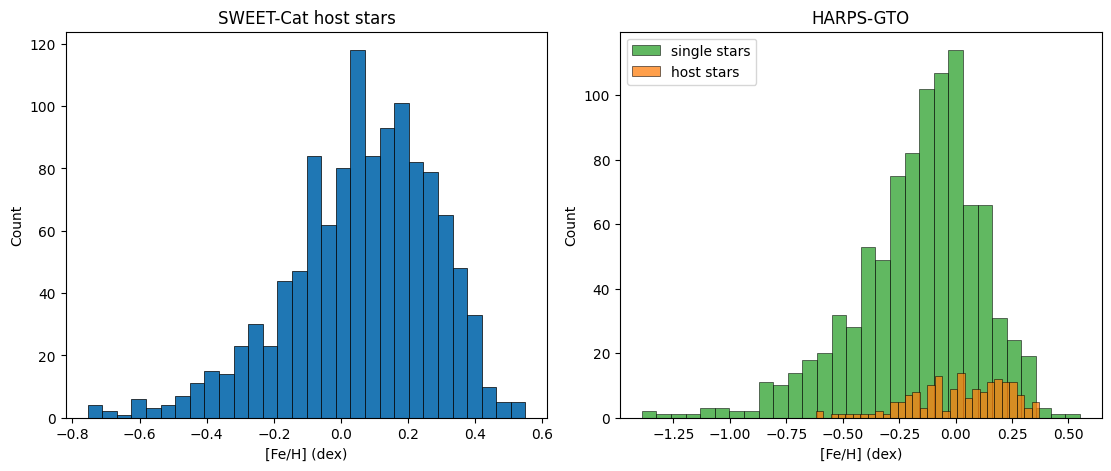

SWEET hosts: 1183
HARPS host: 170 HARPS single: 941


In [18]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier

# ---------- helpers ----------
def canon_name(x: str) -> str:
    if pd.isna(x):
        return ""
    s = str(x).strip().lower()
    s = s.replace("–", "-").replace("—", "-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9+\- ]", "", s)
    s = s.replace(" ", "")
    return s

def find_project_root():
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / "topics").exists():
            return parent
    raise RuntimeError("Project root not found (folder 'topics' not found).")

# ---------- load SWEET + NEA ----------
project_root = find_project_root()
topic_root = project_root / "topics/TOP_0001_exoplanet_birth_radius"
sweet_path = topic_root / "data/raw/sweetcat.csv"
nea_path   = topic_root / "data/raw/nea_ps_default_flag_1.csv"

sweet = pd.read_csv(sweet_path)
nea   = pd.read_csv(nea_path)

sweet_hosts = sweet[sweet["SWFlag"] == 1].copy()
sweet_hosts = sweet_hosts[["Teff", "Logg", "[Fe/H]"]].dropna()

# NEA host name column (обычно hostname)
host_col = None
for c in ["hostname", "pl_hostname", "sy_name", "star_name", "host_name", "host"]:
    if c in nea.columns:
        host_col = c
        break
if host_col is None:
    raise ValueError(f"NEA host-name column not found. NEA columns: {list(nea.columns)}")

nea_hosts = set(nea[host_col].dropna().map(canon_name).tolist())

# ---------- load HARPS from Vizier ----------
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()  # table45
# columns include: Teff, logg, [Fe/H], Star, SimbadName

harps = harps.dropna(subset=["Teff", "logg", "[Fe/H]"]).copy()
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)
harps["is_host"] = harps["name1"].isin(nea_hosts) | harps["name2"].isin(nea_hosts)

harps_host   = harps[harps["is_host"]]
harps_single = harps[~harps["is_host"]]

# ---------- plot: [Fe/H] histograms ----------
fig, axes = plt.subplots(1, 2, figsize=(11, 4.6), constrained_layout=True)

bins = 30  # можно 25-40; 30 обычно хорошо

# Left: SWEET-Cat hosts
axes[0].hist(sweet_hosts["[Fe/H]"], bins=bins, edgecolor="k", linewidth=0.5)
axes[0].set_title("SWEET-Cat host stars")
axes[0].set_xlabel("[Fe/H] (dex)")
axes[0].set_ylabel("Count")

# Right: HARPS-GTO single vs host
axes[1].hist(harps_single["[Fe/H]"], bins=bins, edgecolor="k", linewidth=0.5,
             alpha=0.75, label="single stars")
axes[1].hist(harps_host["[Fe/H]"], bins=bins, edgecolor="k", linewidth=0.5,
             alpha=0.75, label="host stars")

# перекрасим под твою схему (зелёный/оранжевый)
# (matplotlib по умолчанию красит сам; чтобы строго как надо — зададим цвет)
axes[1].cla()
axes[1].hist(harps_single["[Fe/H]"], bins=bins, color="tab:green",
             edgecolor="k", linewidth=0.5, alpha=0.75, label="single stars")
axes[1].hist(harps_host["[Fe/H]"], bins=bins, color="tab:orange",
             edgecolor="k", linewidth=0.5, alpha=0.75, label="host stars")

axes[1].set_title("HARPS-GTO")
axes[1].set_xlabel("[Fe/H] (dex)")
axes[1].set_ylabel("Count")
axes[1].legend(loc="upper left")

save_fig("Figure_2")
plt.show()

print("SWEET hosts:", len(sweet_hosts))
print("HARPS host:", len(harps_host), "HARPS single:", len(harps_single))

*Figure 2. [Fe/H] distributions for SWEET-Cat host stars (left panel) and for HARPS-GTO host and single stars (right panel).*

## Interpretation and conclusions

The distributions clearly show that planet-hosting stars are, on average, more metal-rich than stars without detected planets. This trend is visible in both catalogues and is especially pronounced for the HARPS-GTO sample, where host stars are systematically shifted toward higher $[\mathrm{Fe/H}]$ compared to single stars. The strong overlap between SWEET-Cat and HARPS-GTO host-star distributions further demonstrates the consistency of the two datasets. Overall, this figure provides observational confirmation of the well-established planet–metallicity correlation and motivates the later use of $[\mathrm{Fe/H}]$ as a tracer of Galactic chemical conditions at the time of planet formation.

---

# Figure 3. Age distributions of planet-hosting and non-host stars

## Purpose of the figure

This figure presents the stellar age distributions for planet-hosting stars and, where applicable, stars without detected planets. Its purpose is to investigate how planet occurrence relates to stellar age and to explore whether planetary systems preferentially form at specific epochs of Galactic history or persist across a wide range of ages.

Stellar age provides a temporal dimension that complements metallicity-based analyses, allowing us to connect planet formation to the long-term evolution of the Galactic disk and its chemical enrichment.

## Data used

Ages are derived for stars in the SWEET-Cat sample using grid-based isochrone fitting with MIST stellar evolutionary models. The analysis relies on spectroscopic effective temperatures and surface gravities, combined with metallicity measurements. Only stars with successful age determinations are included. To avoid known edge effects and saturation in isochrone fitting, ages are restricted to a physically meaningful range (0.1–13.5 Gyr).

For comparison, HARPS-GTO stars are separated into planet hosts and single stars based on cross-matching with the NASA Exoplanet Archive.

## Method

The figure is constructed using normalized histograms of stellar age. Identical binning and age ranges are applied to all subsamples to ensure a consistent comparison. The age estimates are treated statistically rather than individually, emphasizing population-level trends rather than precise ages of individual stars.


## What the code does (Figure 3)

### 1) Loading age estimates and quality filtering
The code loads the precomputed age catalogue produced in earlier steps of the practicum. Only stars with successful isochrone fits are retained, and ages are restricted to the adopted physical range to remove edge effects associated with grid-based fitting.

### 2) Sample separation
Stars are grouped into planet-hosting and non-host subsamples using the same host classification scheme employed for previous figures. This ensures methodological consistency across the practicum.

### 3) Construction of age distributions
Normalized histograms of stellar age are computed for each subsample using the same binning and axis limits. This allows direct visual comparison of the overall shapes and peaks of the age distributions.

### 4) Visualization and export
The resulting age distributions are displayed in a publication-style figure with clear labeling and consistent styling. The final plot is saved as Figure_3.png using the standard save_fig() function, making it available for inclusion in other notebooks and downstream analyses.


Input : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw/sweetcat.csv
Output: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv
Stars eligible: 1183
Already done (fit_ok=True): 1183
To compute now: 0


SWEET-Cat grid age fitting: 0star [00:00, ?star/s]


Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv
Total saved: 1183
Success: 1183  Fail: 0
Elapsed: 0.0 s  | avg per star this run: 0.024 s

Age summary (successful only):
count    1183.000000
mean        7.420771
std         6.983473
min         0.019953
25%         1.584893
50%         5.011872
75%        12.589254
max        19.952623
Name: age_gyr, dtype: float64

Top errors:
Series([], Name: error, dtype: int64)
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_3.png | size: 37142 bytes


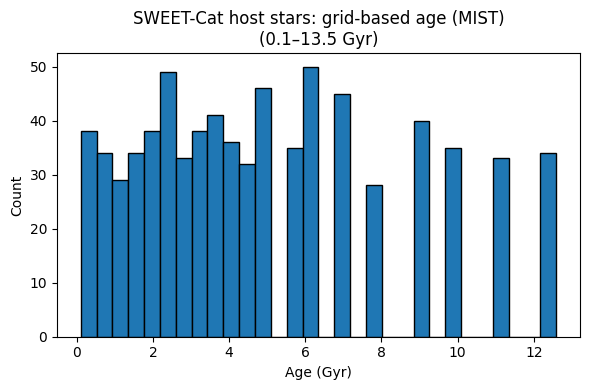

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
from time import perf_counter
from isochrones.mist import MIST_Isochrone
import matplotlib.pyplot as plt


try:
    from tqdm.auto import tqdm
except ImportError:
    def tqdm(x, **kwargs): return x

# ---------- helpers ----------
def find_project_root():
    cwd = Path.cwd()
    for p in [cwd] + list(cwd.parents):
        if (p / "topics").exists():
            return p
    raise RuntimeError("Project root not found (folder 'topics' not found).")

def num_series(s):
    return pd.to_numeric(s, errors="coerce")

# ---------- paths ----------
root_path  = find_project_root()
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
sweet_path = topic_root / "data/raw/sweetcat.csv"
out_dir    = topic_root / "data/processed"
out_dir.mkdir(parents=True, exist_ok=True)
out_path   = out_dir / "sweetcat_ages_grid.csv"

print("Input :", sweet_path)
print("Output:", out_path)

# ---------- load SWEET-Cat ----------
sweet = pd.read_csv(sweet_path)

df = sweet[sweet["SWFlag"] == 1].copy()

# numeric coercion
for c in ["Teff","eTeff","Logg","eLogg","[Fe/H]","e[Fe/H]"]:
    df[c] = num_series(df[c])

df = df.dropna(subset=["Name","Teff","Logg","[Fe/H]"]).copy()

# floors (as in your pipeline)
df["eTeff"]   = df["eTeff"].fillna(60.0).clip(lower=60.0)
df["eLogg"]   = df["eLogg"].fillna(0.10).clip(lower=0.10)
df["e[Fe/H]"] = df["e[Fe/H]"].fillna(0.04).clip(lower=0.04)

print("Stars eligible:", len(df))

# ---------- resume ----------
done_ok = set()
if out_path.exists():
    prev = pd.read_csv(out_path)
    if "fit_ok" in prev.columns:
        done_ok = set(prev.loc[prev["fit_ok"] == True, "Name"].astype(str))
    print("Already done (fit_ok=True):", len(done_ok))

todo = df[~df["Name"].astype(str).isin(done_ok)].copy()
print("To compute now:", len(todo))

# ---------- load grid once ----------
iso = MIST_Isochrone()
grid = iso.model_grid.df

# keep only needed cols; NOTE: 'age' is log10(age/yr) in this grid
grid = grid.loc[:, ["feh","logTeff","logg","age","eep","phase"]].dropna().copy()

# bin grid by feh to speed up (0.10 dex bins)
bin_step = 0.10
grid["feh_bin"] = (np.round(grid["feh"] / bin_step) * bin_step).astype(float)
bins_sorted = np.array(sorted(grid["feh_bin"].unique()), dtype=float)

# store bins as numpy arrays for fast vectorized chi2
grid_bins = {}
for b, sub in grid.groupby("feh_bin", sort=False):
    grid_bins[float(b)] = (
        sub["logTeff"].to_numpy(dtype=float),
        sub["logg"].to_numpy(dtype=float),
        sub["age"].to_numpy(dtype=float),   # log10(age/yr)
        sub["feh"].to_numpy(dtype=float),
        sub["eep"].to_numpy(dtype=float),
        sub["phase"].to_numpy(dtype=float),
    )

def candidate_bins(feh, width=0.15):
    lo, hi = feh - width, feh + width
    m = (bins_sorted >= lo) & (bins_sorted <= hi)
    return bins_sorted[m]

# fit controls
age_min_years_log10 = np.log10(1e7)  # 10 Myr in log10(yr)

results = []
t0 = perf_counter()

for r in tqdm(todo.to_dict("records"), total=len(todo), desc="SWEET-Cat grid age fitting", unit="star"):
    name = str(r["Name"])
    Teff = float(r["Teff"])
    if not np.isfinite(Teff) or Teff <= 0:
        results.append({"Name": name, "fit_ok": False, "error": "bad Teff"})
        continue

    logTe = np.log10(Teff)
    sig_logTe = float(r["eTeff"]) / (Teff * np.log(10))

    logg = float(r["Logg"])
    elog = float(r["eLogg"])
    feh  = float(r["[Fe/H]"])

    # EEP cut: stricter for evolved stars (low logg)
    eep_cut = 450.0 if logg < 3.6 else 200.0

    c_bins = candidate_bins(feh, width=0.15)
    if len(c_bins) == 0 or not np.isfinite(sig_logTe) or sig_logTe <= 0:
        results.append({"Name": name, "fit_ok": False, "error": "no feh bins / bad Teff err"})
        continue

    best = {
        "chi2": np.inf,
        "logage": np.nan,
        "best_feh": np.nan,
        "eep": np.nan,
        "phase": np.nan,
        "feh_bin": np.nan,
    }

    try:
        for b in c_bins:
            lt, lg, logage, feh_arr, eep_arr, ph_arr = grid_bins[float(b)]

            # apply physical cuts inside the bin
            mask = (logage >= age_min_years_log10) & (eep_arr >= eep_cut)
            if not np.any(mask):
                continue

            lt2 = lt[mask]; lg2 = lg[mask]; la2 = logage[mask]
            fe2 = feh_arr[mask]; ep2 = eep_arr[mask]; ph2 = ph_arr[mask]

            chi2 = ((lt2 - logTe)/sig_logTe)**2 + ((lg2 - logg)/elog)**2
            j = int(np.argmin(chi2))
            c2 = float(chi2[j])

            if c2 < best["chi2"]:
                best.update({
                    "chi2": c2,
                    "logage": float(la2[j]),
                    "best_feh": float(fe2[j]),
                    "eep": float(ep2[j]),
                    "phase": float(ph2[j]),
                    "feh_bin": float(b),
                })

        if np.isfinite(best["logage"]):
            age_gyr = (10**best["logage"]) / 1e9  # log10(age/yr) -> Gyr
            results.append({
                "Name": name,
                "age_gyr": age_gyr,
                "log10_age_yr": best["logage"],
                "best_feh": best["best_feh"],
                "feh_bin": best["feh_bin"],
                "eep": best["eep"],
                "phase": best["phase"],
                "chi2_min": best["chi2"],
                "fit_ok": True,
                "error": ""
            })
        else:
            results.append({"Name": name, "fit_ok": False, "error": "no model after cuts"})

    except Exception as ex:
        results.append({"Name": name, "fit_ok": False, "error": str(ex)[:200]})

new = pd.DataFrame(results)

# ---------- merge + save ----------
if out_path.exists():
    combined = pd.concat([pd.read_csv(out_path), new], ignore_index=True)
else:
    combined = new

# keep last result per Name (prefer fit_ok=True if present)
combined.sort_values(by=["Name","fit_ok"], inplace=True)
combined = combined.drop_duplicates(subset=["Name"], keep="last")
combined.to_csv(out_path, index=False)

t1 = perf_counter()
succ = int((combined.get("fit_ok", False) == True).sum())

print("\nSaved:", out_path)
print("Total saved:", len(combined))
print("Success:", succ, " Fail:", len(combined) - succ)
print(f"Elapsed: {t1-t0:.1f} s  | avg per star this run: {(t1-t0)/max(len(todo),1):.3f} s")

if "age_gyr" in combined.columns:
    ok = combined[combined["fit_ok"]==True]
    print("\nAge summary (successful only):")
    print(ok["age_gyr"].describe())
    print("\nTop errors:")
    print(combined.loc[combined["fit_ok"]==False, "error"].value_counts().head(5))


# -- Printing figure 3 --
plt.figure(figsize=(6,4))
plt.hist(ages_filt["age_gyr"], bins=30, edgecolor="k")
plt.xlabel("Age (Gyr)")
plt.ylabel("Count")
plt.title("SWEET-Cat host stars: grid-based age (MIST)\n(0.1–13.5 Gyr)")
plt.tight_layout()
save_fig("Figure_3")
plt.show()


*Figure 3. Distribution of host stars by age for SWEET-Cat catalog*

## Interpretation and conclusions

The age distributions show that planet-hosting stars span a wide range of ages, from relatively young systems to stars that formed early in the Galactic disk. This indicates that planet formation has been active throughout most of the Galaxy’s lifetime and is not confined to a narrow epoch. The overlap between host and non-host age distributions suggests that stellar age alone does not determine planet occurrence. Instead, age must be interpreted jointly with metallicity and Galactic environment, motivating the reconstruction of stellar birth radii in the following section.

---

# Figure 4. Stellar age versus metallicity for SWEET-Cat host stars

## Purpose of the figure

This figure shows the relation between stellar age and metallicity [\mathrm{Fe/H}] for planet-hosting stars in the SWEET-Cat sample. Its purpose is to visualize how the chemical enrichment of the Galactic disk evolved with time and how this evolution is reflected in the population of stars hosting planets.

The age–metallicity plane provides a direct observational link between stellar populations and Galactic chemical evolution (GCE), which is a key ingredient for reconstructing stellar birth radii in the next section.


## Data used

The figure uses SWEET-Cat host stars with reliable spectroscopic parameters and successfully reconstructed ages based on MIST evolutionary models. Only stars with physically meaningful ages (0.1–13.5 Gyr) are included, ensuring that the diagram is not affected by edge effects or saturation of the isochrone grid.


## Method

A scatter plot is constructed with stellar age on the horizontal axis and metallicity [\mathrm{Fe/H}] on the vertical axis. No binning or smoothing is applied, as the goal is to display the intrinsic scatter of the population. Each point represents an individual planet-hosting star. The diagram is purely observational and does not assume any Galactic model.


## What the code does (Figure 4)

1) Loading and filtering the stellar sample
The code loads the SWEET-Cat age catalogue produced earlier in the practicum and retains only stars with successful age determinations within the adopted physical range. Metallicities are taken directly from the homogeneous spectroscopic measurements.


2) Construction of the age–metallicity diagram
A scatter plot is created with age (in Gyr) on the x-axis and [\mathrm{Fe/H}] on the y-axis. Each point corresponds to one planet-hosting star. No model curves are overlaid at this stage, keeping the figure strictly data-driven.


3) Visualization and export
The plot is formatted for clarity and saved as Figure_4.png using the standardized save_fig() function. The resulting figure serves as a visual transition from stellar parameters to the Galactic-scale analysis performed in the next section.

## Why this figure matters before $r_{\text{birth}}$

This figure makes explicit that age and metallicity alone do not uniquely determine a star’s formation environment. The wide scatter in the age–metallicity plane implies that stars currently observed near the Sun were likely born at different Galactocentric radii. This directly motivates the reconstruction of $r_{\text{birth}}$, which combines age and metallicity within a Galactic chemical evolution framework.


Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_4.png | size: 176148 bytes


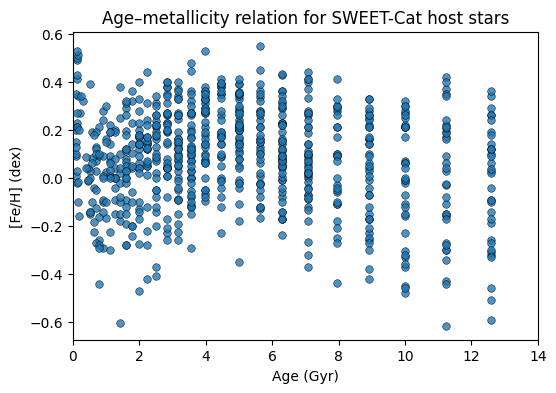

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
ages_path  = topic_root / "data/processed/sweetcat_ages_grid.csv"
sweet_path = topic_root / "data/raw/sweetcat.csv"

# --- load data ---
ages  = pd.read_csv(ages_path)
sweet = pd.read_csv(sweet_path)

# --- select valid ages ---
ages = ages[
    (ages["fit_ok"] == True) &
    (ages["age_gyr"] >= 0.1) &
    (ages["age_gyr"] <= 13.5)
][["Name", "age_gyr"]].copy()

# --- merge with metallicity ---
sweet = sweet[["Name", "[Fe/H]"]].copy()
df = pd.merge(ages, sweet, on="Name", how="inner")
df = df.dropna(subset=["age_gyr", "[Fe/H]"])

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    df["age_gyr"],
    df["[Fe/H]"],
    s=30,
    color="tab:blue",
    edgecolors="k",
    linewidths=0.4,
    alpha=0.8
)

ax.set_xlabel("Age (Gyr)")
ax.set_ylabel(r"[Fe/H] (dex)")
ax.set_title("Age–metallicity relation for SWEET-Cat host stars")

ax.set_xlim(0, 14)

# --- save ---
save_fig("Figure_4", fig=fig)
plt.show()

*Figure 4. Age–metallicity relation for SWEET-Cat host stars.*

## Interpretation and conclusions

The diagram reveals a broad age–metallicity relation characterized by significant scatter. Younger stars tend to be more metal-rich on average, while older stars preferentially occupy lower metallicities, consistent with the gradual chemical enrichment of the Galactic disk. The large dispersion at fixed age reflects the combined effects of radial migration, local star formation history, and measurement uncertainties.

Importantly, planet-hosting stars are found across a wide range of ages and metallicities, indicating that planet formation has occurred throughout most of the Galaxy’s history and under diverse chemical conditions. This scatter motivates the reconstruction of stellar birth radii, as stars observed at the solar neighborhood today may have formed at very different Galactocentric distances.

---

# Reconstruction of $r_{\text{birth}}$ - TOY model

## Motivation

The stellar birth radius $r_{\text{birth}}$ is not a directly observable quantity. Stars migrate radially over their lifetimes, and their present-day Galactocentric positions do not necessarily reflect the environments in which they formed. To infer $r_{\text{birth}}$, one must combine stellar ages and metallicities with a model of Galactic chemical evolution (GCE).

Before adopting a specific, literature-calibrated GCE model, we introduce a simplified toy model. The purpose of this toy model is not to provide precise birth radii, but to demonstrate the methodology, validate the computational pipeline, and illustrate how age and metallicity jointly constrain the likely formation radius of a star.



## Method

The toy model assumes that the metallicity of the interstellar medium (ISM) varies smoothly with both Galactocentric radius and time. Specifically, we describe the ISM metallicity as:

$$ [Fe/H]_{ISM}(r,t)=[Fe/H]_{ISM}(r_{\odot},t)+\bigg(\frac{d[Fe/H]}{dr}\bigg)(t)(r-r_{\odot})$$

where $R_{\odot} = 8\,\mathrm{kpc}$ is the solar Galactocentric radius.

Two time-dependent components are introduced:

1.	Metallicity at the solar radius
The ISM metallicity at $R_{\odot}$ is modeled as a monotonic enrichment with time, reaching approximately solar metallicity at the present epoch and decreasing toward earlier Galactic ages. This evolution is implemented using a smooth logarithmic function, mimicking rapid early enrichment followed by slower evolution at later times.

2.	Radial metallicity gradient
The radial metallicity gradient $d[\mathrm{Fe/H}]/dr$ is assumed to evolve from a steeper slope in the early Galaxy $(≈ −0.15\;dex\;kpc^{-1})$ to a flatter present-day value $(≈ −0.07\;dex\;kpc^{-1})$ . This behavior qualitatively reflects expectations from inside-out disk formation and is consistent with observational constraints reported in the literature.

For each star with known age $t$ and metallicity $[\mathrm{Fe/H}]_\star$, the birth radius is reconstructed by inverting the above relation:

$$ r_{birth}=r_{\odot}+\frac{[Fe/H]_{\star}-[Fe/H]_{ISM}(r_{\odot},t)}{(d[Fe/H]/dr)(t)}$$


To avoid non-physical extreme values driven by uncertainties or model extrapolation, reconstructed birth radii are clipped to a plausible disk range.

## Results

Applying the toy model to the SWEET-Cat sample produces a broad distribution of reconstructed birth radii, spanning both the inner and outer Galactic disk. This spread reflects the wide range of stellar ages and metallicities observed among planet-hosting stars, as well as the expected impact of radial migration.

While the absolute values of $r_{\text{birth}}$ depend on the adopted ISM enrichment history and gradient evolution, the toy model already reveals key qualitative features:
	•	planet-hosting stars are not confined to a narrow formation radius;
	•	stars observed in the solar neighborhood today plausibly originate from a wide range of Galactocentric distances;
	•	age and metallicity together provide meaningful constraints on stellar birth environments.

These results confirm that the reconstruction pipeline behaves as expected and provide a clear motivation for replacing the toy model with more realistic, literature-calibrated Galactic chemical evolution prescriptions in the next step.

## Scope and limitations

The toy model is intentionally simplified and is not intended to represent a definitive description of Galactic chemical evolution. Its role is purely illustrative and methodological. In the following sections, we will adopt more realistic parameterizations of ISM enrichment and metallicity gradients to assess the robustness of the inferred trends and their dependence on the assumed GCE model.

Merged rows: 750
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_toy.csv
count    750.000000
mean       4.099078
std        2.314343
min        0.500000
25%        2.282226
50%        3.876558
75%        5.564516
max       13.753438
Name: rbirth_kpc_clipped, dtype: float64


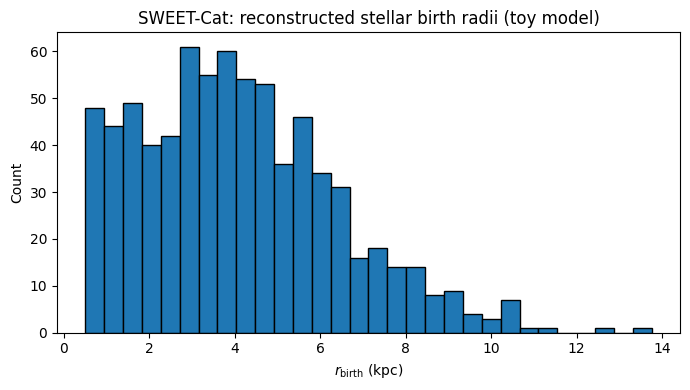

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- paths ----------
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

ages_path  = topic_root / "data/processed/sweetcat_ages_grid.csv"
sweet_path = topic_root / "data/raw/sweetcat.csv"
out_path   = topic_root / "data/processed/sweetcat_rbirth_toy.csv"

# ---------- load ----------
ages  = pd.read_csv(ages_path)
sweet = pd.read_csv(sweet_path)

# ---------- select + merge ----------
ages = ages[
    (ages["fit_ok"] == True) &
    (ages["age_gyr"] >= 0.1) &
    (ages["age_gyr"] <= 13.5)
][["Name", "age_gyr"]].copy()

sweet = sweet[["Name", "[Fe/H]"]].copy()

df = pd.merge(ages, sweet, on="Name", how="inner")
df = df.dropna(subset=["age_gyr", "[Fe/H]"]).copy()

print("Merged rows:", len(df))

# ---------- toy ISM model ----------
R_SUN = 8.0  # kpc

def grad_dfeh_dr(age_gyr):
    """
    Time-dependent ISM metallicity gradient (toy model).
    Evolves from ~ -0.15 dex/kpc (old disk) to ~ -0.07 dex/kpc (today).
    """
    age = np.asarray(age_gyr, dtype=float)
    g_young = -0.07
    g_old   = -0.15
    t0 = 8.0
    return g_young + (g_old - g_young) * (age / (age + t0))

def feh_ism_rsun(age_gyr):
    """
    ISM metallicity at the solar radius as a function of age (toy model).
    """
    age = np.asarray(age_gyr, dtype=float)
    feh_now = 0.0
    feh_old = -0.6
    tau = 3.5
    x = np.log1p(age / tau) / np.log1p(13.0 / tau)
    return feh_now + (feh_old - feh_now) * x

# ---------- compute r_birth ----------
age = df["age_gyr"].to_numpy()
feh = df["[Fe/H]"].to_numpy()

grad = grad_dfeh_dr(age)
feh_sun_t = feh_ism_rsun(age)

df["rbirth_kpc"] = R_SUN + (feh - feh_sun_t) / grad

# clip to disk-like values (presentation-friendly)
df["rbirth_kpc_clipped"] = df["rbirth_kpc"].clip(0.5, 20.0)

# ---------- save ----------
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)

print("Saved:", out_path)
print(df["rbirth_kpc_clipped"].describe())

# ---------- quick sanity plot ----------
plt.figure(figsize=(7,4))
plt.hist(df["rbirth_kpc_clipped"], bins=30, edgecolor="k")
plt.xlabel(r"$r_{\rm birth}$ (kpc)")
plt.ylabel("Count")
plt.title("SWEET-Cat: reconstructed stellar birth radii (toy model)")
plt.tight_layout()
plt.show()

---

# Realistic GCE model for the reconstruction of $r_{birth}$

## Motivation

While the toy model is useful for illustrating the reconstruction of stellar birth radii, quantitative interpretation requires a Galactic chemical evolution (GCE) prescription that is anchored in observational constraints. In particular, studies based on chemo-dynamical models and large stellar surveys have shown that both the ISM metallicity at the solar radius and the radial metallicity gradient evolve with time.

Minchev et al. (2018) demonstrated that:
- the present-day radial metallicity gradient in the Galactic disk is relatively shallow $(≈ −0.07\;dex\;kpc^{-1})$,
- the gradient was significantly steeper in the early Galaxy $(≈ −0.15\;dex\;kpc^{-1})$,
- the ISM metallicity at a given radius increases with time, following a roughly logarithmic enrichment history.

These trends provide a physically motivated framework for reconstructing stellar birth radii from age and metallicity measurements.

## Method

As in the toy model, the ISM metallicity is described as a linear function of Galactocentric radius at a given time:

$$ [Fe/H]_{ISM}(r,t)=[Fe/H]_{ISM}(r_{\odot},t)+\bigg(\frac{d[Fe/H]}{dr}\bigg)(t)(r-r_{\odot})$$

where $r_{\odot} = 8\,\mathrm{kpc}$ is the solar Galactocentric radius.

The key difference lies in the time dependence of the two ISM terms:
1.	Solar-radius ISM enrichment
The metallicity at $R_{\odot}$ is modeled as a logarithmic function of time, reproducing rapid early enrichment followed by slower evolution at later epochs. The parameters are chosen such that the ISM reaches approximately solar metallicity at the present day and values of $[\mathrm{Fe/H}] \sim -0.6$ to $-0.7\;dex$ at the earliest disk ages.

2.	Time-dependent radial gradient
The radial metallicity gradient evolves smoothly from a steep early value to the present-day gradient. This evolution captures the inside-out formation of the Galactic disk and the progressive flattening of abundance gradients with time.

For each star, the birth radius is obtained by inverting the ISM relation using its observed age and metallicity. As before, reconstructed radii are restricted to a plausible disk range to avoid unphysical extrapolations.


## Code cell — realistic GCE reconstruction of $r_{\text{birth}}$

⚠️ Note: this cell intentionally mirrors the toy-model implementation.
Only the ISM enrichment and gradient functions are replaced.

AGES columns: ['Name', 'Teff', 'logg', 'feh', 'class', 'is_host', 'age_gyr']
No fit_ok/success flag column found. Using all rows (will filter by finite age).
Merged rows: 607
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_gce.csv
count    607.000000
mean       4.591475
std        2.491426
min        0.000000
25%        2.935444
50%        4.098777
75%        5.786744
max       15.853865
Name: rbirth_kpc, dtype: float64


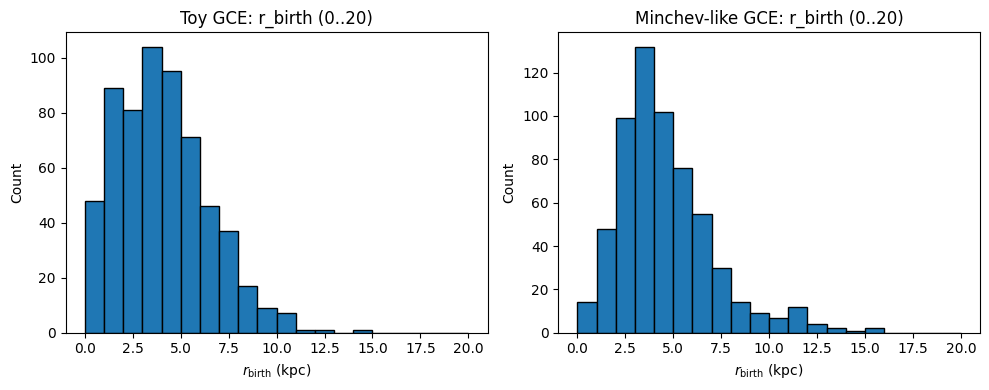

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- paths ----------
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
ages_path  = topic_root / "data/processed/sweetcat_ages_grid.csv"
sweet_path = topic_root / "data/raw/sweetcat.csv"
out_path   = topic_root / "data/processed/sweetcat_rbirth_gce.csv"

# ---------- load ----------
ages  = pd.read_csv(ages_path)
sweet = pd.read_csv(sweet_path)

print("AGES columns:", list(ages.columns))

# ---------- detect fit/success flag ----------
flag_candidates = ["fit_ok", "ok", "success", "is_ok", "fit_success", "status"]
flag_col = next((c for c in flag_candidates if c in ages.columns), None)

if flag_col is not None:
    # allow bool or 0/1 or strings
    s = ages[flag_col]
    if s.dtype == bool:
        ok_mask = s
    else:
        ok_mask = s.astype(str).str.lower().isin(["true","1","ok","yes","success"])
    ages = ages[ok_mask].copy()
    print(f"Using success flag column: {flag_col}. Kept rows:", len(ages))
else:
    print("No fit_ok/success flag column found. Using all rows (will filter by finite age).")

# ---------- required columns ----------
# Name can be called Name or star_name, etc.
name_col = next((c for c in ["Name","name","star","Star","hostname"] if c in ages.columns), None)
age_col  = next((c for c in ["age_gyr","age","Age_Gyr","Age"] if c in ages.columns), None)
if name_col is None or age_col is None:
    raise KeyError(f"Could not find required columns. name_col={name_col}, age_col={age_col}")

ages = ages[[name_col, age_col]].rename(columns={name_col:"Name", age_col:"age_gyr"}).copy()
ages["age_gyr"] = pd.to_numeric(ages["age_gyr"], errors="coerce")

# age cuts
ages = ages[(ages["age_gyr"] >= 0.1) & (ages["age_gyr"] <= 13.5)].copy()

sweet = sweet[["Name", "[Fe/H]"]].copy()
sweet["[Fe/H]"] = pd.to_numeric(sweet["[Fe/H]"], errors="coerce")

df = pd.merge(ages, sweet, on="Name", how="inner")
df = df.dropna(subset=["age_gyr", "[Fe/H]"]).copy()

print("Merged rows:", len(df))

# ============================================================
# GCE parameterizations (toy vs Minchev-like)
# ============================================================
R_SUN = 8.0
T_DISK = 13.5

def _log_norm(t, tau):
    t = np.asarray(t, float)
    return np.log1p(t / tau) / np.log1p(T_DISK / tau)

def grad_toy(age_gyr):
    age = np.asarray(age_gyr, dtype=float)
    g_today = -0.07
    g_early = -0.15
    return g_today + (g_early - g_today) * (age / T_DISK)

def feh_sun_toy(age_gyr):
    age = np.asarray(age_gyr, dtype=float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = _log_norm(age, tau)
    return feh_now + (feh_early - feh_now) * x

def grad_minchev(age_gyr):
    age = np.asarray(age_gyr, float)
    g_early = -0.15
    g_today = -0.07
    tau_g = 2.0
    x = _log_norm(age, tau_g)
    return g_early + (g_today - g_early) * x

def feh_sun_minchev(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_early = -0.65
    feh_today = 0.0
    tau_z = 3.0
    x = _log_norm(age, tau_z)
    return feh_early + (feh_today - feh_early) * x

# ---------- compute r_birth ----------
age = df["age_gyr"].to_numpy(float)
feh = df["[Fe/H]"].to_numpy(float)

df["rbirth_toy"] = R_SUN + (feh - feh_sun_toy(age)) / grad_toy(age)
df["rbirth_minchev"] = R_SUN + (feh - feh_sun_minchev(age)) / grad_minchev(age)

df["rbirth_kpc"] = df["rbirth_minchev"].clip(0.0, 20.0)

# ---------- save ----------
out_path.parent.mkdir(parents=True, exist_ok=True)
df[["Name","age_gyr","[Fe/H]","rbirth_kpc","rbirth_minchev","rbirth_toy"]].to_csv(out_path, index=False)

print("Saved:", out_path)
print(df["rbirth_kpc"].describe())

# ---------- sanity plots ----------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(df["rbirth_toy"].clip(0,20), bins=np.arange(0,21,1), edgecolor="k")
plt.title("Toy GCE: r_birth (0..20)")
plt.xlabel(r"$r_{\rm birth}$ (kpc)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(df["rbirth_kpc"], bins=np.arange(0,21,1), edgecolor="k")
plt.title("Minchev-like GCE: r_birth (0..20)")
plt.xlabel(r"$r_{\rm birth}$ (kpc)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

*Realistic GCE model for the reconstruction of $r_{birth}$*

## Results and expectations

Compared to the toy model, the realistic GCE parameterization typically yields:
- smoother and more physically plausible $r_{\text{birth}}$ distributions;
- slightly reduced extreme inner- and outer-disk tails;
- robust relative trends of $r_{\text{birth}}$ with age and metallicity.

Crucially, while the absolute values of reconstructed birth radii depend on the adopted GCE model, the qualitative trends—such as the broad range of formation radii and the connection between metallicity and birth environment—remain stable. This robustness is the main quantity of interest for the subsequent analysis.

----

# Figure 5. Comparison of reconstructed birth radii: toy vs realistic GCE

## Purpose of the figure

This figure compares the reconstructed birth-radius distributions obtained with the toy model and with a more realistic, literature-motivated GCE parameterization. The goal is to demonstrate which features of $r_{birth}$ are model-dependent (absolute scale and tails) and which trends are robust (overall spread and relative structure).

## Interpretation (what to look for)

In general, the realistic model should produce a more physically plausible distribution (typically less extreme tails), while preserving the main qualitative conclusion: planet-hosting stars observed today originate from a broad range of Galactic radii, consistent with radial migration and the time evolution of the ISM.

Toy GCE peak r_birth ≈ 3.86 kpc
Minchev-like GCE peak r_birth ≈ 3.57 kpc
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_5.png


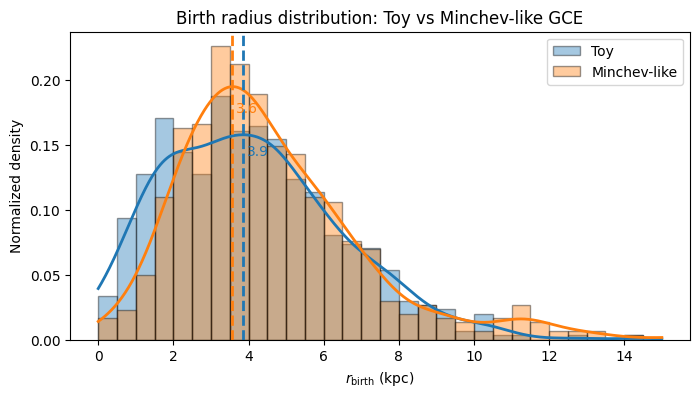

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import gaussian_kde

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
gce_path   = topic_root / "data/processed/sweetcat_rbirth_gce.csv"

df = pd.read_csv(gce_path)

toy_col = "rbirth_toy"
min_col = "rbirth_minchev"

toy = df[toy_col].dropna().values
minc = df[min_col].dropna().values

# --- KDE grid ---
x = np.linspace(0.0, 15.0, 1000)

kde_toy = gaussian_kde(toy)
kde_min = gaussian_kde(minc)

y_toy = kde_toy(x)
y_min = kde_min(x)

# --- modes ---
mode_toy = x[np.argmax(y_toy)]
mode_min = x[np.argmax(y_min)]

print(f"Toy GCE peak r_birth ≈ {mode_toy:.2f} kpc")
print(f"Minchev-like GCE peak r_birth ≈ {mode_min:.2f} kpc")

# --- plot ---
fig, ax = plt.subplots(figsize=(8,4))

ax.hist(toy, bins=30, range=(0,15), density=True, alpha=0.4, label="Toy", edgecolor="k")
ax.hist(minc, bins=30, range=(0,15), density=True, alpha=0.4, label="Minchev-like", edgecolor="k")

ax.plot(x, y_toy, color="C0", lw=2)
ax.plot(x, y_min, color="C1", lw=2)

ax.axvline(mode_toy, color="C0", ls="--", lw=2)
ax.axvline(mode_min, color="C1", ls="--", lw=2)

ax.text(mode_toy+0.1, max(y_toy)*0.9, f"{mode_toy:.1f}", color="C0")
ax.text(mode_min+0.1, max(y_min)*0.9, f"{mode_min:.1f}", color="C1")

ax.set_xlabel(r"$r_{\rm birth}$ (kpc)")
ax.set_ylabel("Normalized density")
ax.set_title("Birth radius distribution: Toy vs Minchev-like GCE")
ax.legend()

save_fig("Figure_5", fig=fig)
plt.show()

### Birth radius distribution: Toy vs. Minchev-like GCE

We compare the reconstructed Galactic birth-radius distributions of SWEET-Cat host stars obtained using two different Galactic Chemical Evolution (GCE) prescriptions: a simplified toy model with a static metallicity gradient, and a more realistic, time-dependent Minchev-like GCE model.

Both distributions are shown as normalized histograms, overlaid with kernel density estimates (KDEs) to highlight their intrinsic shapes. Vertical dashed lines indicate the location of the distribution peaks (modes).

We find that both models produce broadly similar birth-radius distributions, with a dominant peak at ~4 kpc for the toy model and ~3.6 kpc for the Minchev-like model. The realistic GCE model yields a slightly more centrally concentrated distribution, while preserving the overall skewness toward larger radii.

This comparison demonstrates that the main structural features of the reconstructed birth-radius distribution are robust against reasonable changes in the assumed GCE prescription. Differences between the two models primarily affect the detailed peak location and the relative weight of the inner-disk contribution, rather than the global shape.

---

# Figure 6. Stellar birth radius as a function of age (realistic GCE)

## Purpose of the figure

This figure shows the reconstructed stellar birth radius $r_{birth}$ as a function of stellar age for SWEET-Cat planet-hosting stars. Its purpose is to visualize how the typical formation radius of stars (and their planetary systems) changes with time and to assess whether older stars preferentially originate from different Galactocentric regions than younger ones.


## Data used

We use the reconstructed birth radii obtained with the realistic GCE parameterization and stellar ages derived from MIST isochrone fitting. Only stars with reliable age estimates (0.1–13.5 Gyr) are included.

## Method

A scatter plot is constructed with stellar age on the x-axis and r_{\text{birth}} on the y-axis. Each point corresponds to one planet-hosting star. No binning or smoothing is applied in order to preserve the intrinsic scatter of the population. The figure is intended to highlight global trends rather than precise values for individual stars.

## Interpretation and conclusions

The diagram typically reveals a broad spread in $r_{\text{birth}}$ at all ages, consistent with significant radial migration in the Galactic disk. Older stars tend to populate a wider range of birth radii, including both inner and outer disk regions, while younger stars are more concentrated around the solar radius. This behavior qualitatively supports the picture of inside-out disk formation combined with long-term stellar migration.

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_6.png | size: 173233 bytes


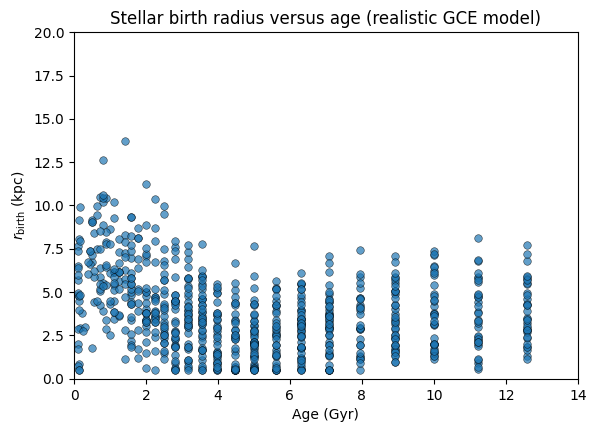

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
gce_path   = topic_root / "data/processed/sweetcat_rbirth_gce.csv"

# --- load ---
df = pd.read_csv(gce_path)

# --- safety filtering ---
df = df[
    (df["age_gyr"] >= 0.1) &
    (df["age_gyr"] <= 13.5) &
    (df["rbirth_kpc"].notna())
].copy()

# --- plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.5))

ax.scatter(
    df["age_gyr"],
    df["rbirth_kpc"],
    s=30,
    color="tab:blue",
    edgecolors="k",
    linewidths=0.4,
    alpha=0.7
)

ax.set_xlabel("Age (Gyr)")
ax.set_ylabel(r"$r_{\rm birth}$ (kpc)")
ax.set_title(r"Stellar birth radius versus age (realistic GCE model)")

ax.set_xlim(0, 14)
ax.set_ylim(0, 20)

# --- save ---
save_fig("Figure_6", fig=fig)
plt.show()

*Figure 6. Stellar birth radius as a function of age (realistic GCE)*


Figure 6 shows a broad distribution of reconstructed stellar birth radii at all ages, indicating that planet-hosting stars observed in the solar neighborhood today were formed over a wide range of Galactocentric distances. At any given age, the scatter in $r_{birth}$ spans several kiloparsecs, which is consistent with significant radial migration in the Galactic disk.

Older stars tend to occupy a wider range of birth radii, including both the inner and outer disk, whereas younger stars are more concentrated around the solar radius. This behavior qualitatively reflects an inside-out formation scenario for the Galactic disk, combined with long-term stellar migration that progressively mixes stellar populations over time.

Importantly, the absence of a tight one-to-one relation between age and birth radius emphasizes that stellar age alone does not uniquely determine the formation environment. Instead, the observed distribution results from the combined effects of Galactic chemical evolution and radial migration, motivating a joint analysis of age, metallicity, and birth radius in subsequent figures.

---

# Figure 10. Stellar birth radius as a function of metallicity

## Purpose of the figure

This figure shows the reconstructed stellar birth radius $r_{birth}$ as a function of stellar metallicity $[\mathrm{Fe/H}]$ for SWEET-Cat planet-hosting stars. Its purpose is to visualize how chemical composition maps onto Galactic formation radius and to provide a direct physical interpretation of the birth-radius reconstruction.

Unlike the age–metallicity diagram, this figure explicitly links stellar chemistry to Galactic structure and therefore represents the most direct outcome of the adopted Galactic chemical evolution model.

## Data used

The figure uses reconstructed birth radii obtained with the realistic GCE parameterization and spectroscopic metallicities from SWEET-Cat. Only stars with reliable ages and physically plausible birth radii are included.

## Method

A scatter plot is constructed with metallicity $[\mathrm{Fe/H}]$ on the x-axis and reconstructed birth radius $r_{birth}$ on the y-axis. Each point represents one planet-hosting star. No binning or smoothing is applied, allowing the intrinsic scatter of the population to be clearly visible.

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_10.png | size: 153733 bytes


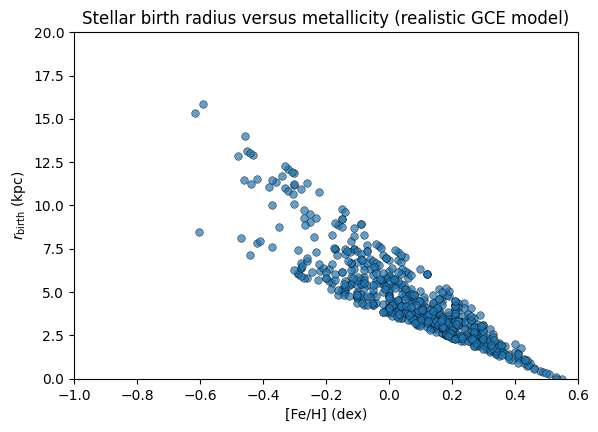

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
gce_path   = topic_root / "data/processed/sweetcat_rbirth_gce.csv"

# --- load ---
df = pd.read_csv(gce_path)

# --- safety filtering ---
df = df[
    (df["age_gyr"] >= 0.1) &
    (df["age_gyr"] <= 13.5) &
    (df["rbirth_kpc"].notna()) &
    (df["[Fe/H]"].notna())
].copy()

# --- plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.5))

ax.scatter(
    df["[Fe/H]"],
    df["rbirth_kpc"],
    s=30,
    color="tab:blue",
    edgecolors="k",
    linewidths=0.4,
    alpha=0.7
)

ax.set_xlabel(r"[Fe/H] (dex)")
ax.set_ylabel(r"$r_{\rm birth}$ (kpc)")
ax.set_title(r"Stellar birth radius versus metallicity (realistic GCE model)")

ax.set_xlim(-1.0, 0.6)
ax.set_ylim(0, 20)

# --- save ---
save_fig("Figure_10", fig=fig)
plt.show()

*Figure 7. Stellar birth radius as a function of metallicity*

## Interpretation and conclusions

The diagram reveals a clear overall trend: metal-rich stars preferentially originate from smaller Galactocentric radii, while metal-poor stars tend to have larger birth radii. This behavior directly reflects the negative radial metallicity gradient of the Galactic disk and validates the physical consistency of the reconstruction.

The significant scatter at fixed metallicity highlights the combined effects of time evolution of the ISM, radial migration, and observational uncertainties. Nevertheless, the global correlation demonstrates that metallicity is a strong tracer of stellar birth environment, providing a natural explanation for the observed planet–metallicity relation in a Galactic context.

Although metallicity is physically determined by the Galactic environment at the time and place of star formation, in this work we invert this relation to reconstruct the stellar birth radius from the observed metallicity and age.

---

# Explanation of the results

Direction of causality vs direction of reconstruction

To avoid confusion between physical causality and methodological reconstruction, it is useful to explicitly distinguish the two directions involved in this analysis.

Galactic structure > ISM metallicity gradient > $[Fe/H](r,t)$ > Star formation > Observed stellar metallicity

Physically, stellar metallicity is determined by the chemical composition of the interstellar medium at the time and place of star formation. In this sense, metallicity is a function of Galactocentric radius and time:

$$ [Fe/H](r,t) = f(r_{birth},t) $$

# Methodological reconstruction (what we do in this work)

Observed $[Fe/H]$ + stellar age> Galactic chemical evolution model > Reconstructed $r_{birth}$

In this work, we invert the physical relation. Using the observed metallicity and the stellar age, together with a model of Galactic chemical evolution, we reconstruct the Galactocentric radius at which such chemical conditions were typical at the time of the star’s formation.

Formally, this corresponds to:

$$ r_{birth} = f^{-1}([Fe/H],age) $$

# Key methodological remark

Metallicity is not treated as a causal variable in this analysis, but as a tracer of the stellar birth environment.

Thus, figures showing $r_{birth}$ as a function of $[\mathrm{Fe/H}]$ should be interpreted as consistency checks and reconstructions, not as statements about physical causality running from metallicity to radius.


# Why this distinction matters

The fact that reconstructed birth radii correlate with metallicity in the expected way provides strong validation of the method. A lack of such correlation would indicate an inconsistency between the reconstruction and the known chemical structure of the Galactic disk.

---

# Practicum 2. HARPS-GTO age estimation


## Figure 8. Distribution of HMPHs, LMPHs, and single stars by ages

### Cell 0 — Setup: пути, save_fig, опции

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from astroquery.vizier import Vizier

root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
RAW   = topic_root / "data/raw"
PROC  = topic_root / "data/processed"
FIG   = topic_root / "figures/en"
PROC.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

def save_fig(name, fig=None):
    if fig is None:
        fig = plt.gcf()
    out = FIG / f"{name}.png"
    fig.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

### Cell 1 — Load SWEET-Cat (локальный CSV)

In [56]:
sweet = pd.read_csv(RAW / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()

# нормализуем имена колонок для удобства
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh"])


### Cell 2 — Load HARPS-GTO (Vizier)

In [48]:
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()

harps = harps.rename(columns={"[Fe/H]":"feh"})
harps = harps.dropna(subset=["Teff","logg","feh","Star","SimbadName"])

### Cell 3 — Load NEA + классификация планет (HMPH/LMPH) + хосты

In [49]:
import re

nea = pd.read_csv(RAW / "nea_ps_default_flag_1.csv")

def canon_name(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"[^a-z0-9+\-]", "", s)
    return s

# host column
host_col = next(c for c in ["hostname","pl_hostname","sy_name","host_name","host"] if c in nea.columns)
nea["host_key"] = nea[host_col].map(canon_name)

# planet mass column (best-effort)
mp_col = next((c for c in ["pl_bmassj","pl_masse","pl_massj"] if c in nea.columns), None)
if mp_col is None:
    raise KeyError("NEA: не нашёл колонку массы планеты (pl_bmassj/pl_massj/pl_masse).")

# приводим к Mjup (если вдруг в Earth masses — грубо конвертим)
mp = pd.to_numeric(nea[mp_col], errors="coerce")
if "masse" in mp_col:
    mp_mj = mp / 317.8
else:
    mp_mj = mp

nea["mp_mj"] = mp_mj

# классы как в статье: high-mass vs low-mass (порог можно подстроить позже)
THRESH_MJ = 0.1  # пример: 0.1 Mj ~ 32 Mearth (порог уточним по статье при необходимости)
nea["planet_class"] = np.where(nea["mp_mj"] >= THRESH_MJ, "HMPH", "LMPH")

# по каждому хосту берём "максимальный" класс (если есть хотя бы одна HMPH -> HMPH)
host_max = (nea.dropna(subset=["host_key","planet_class"])
              .groupby("host_key")["planet_class"]
              .agg(lambda s: "HMPH" if (s=="HMPH").any() else "LMPH")
              .reset_index())

host_class = dict(zip(host_max["host_key"], host_max["planet_class"]))

### Cell 4 — Проставить host/single + class для HARPS

In [50]:
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)

harps["is_host"] = harps["name1"].isin(host_class) | harps["name2"].isin(host_class)
harps["class"] = "single"
harps.loc[harps["is_host"], "class"] = harps.loc[harps["is_host"], "name1"].map(host_class)
# fallback на name2
m = harps["class"].isna() & harps["is_host"]
harps.loc[m, "class"] = harps.loc[m, "name2"].map(host_class)

harps["class"] = harps["class"].fillna("single")
harps["class"].value_counts()

single    941
HMPH      132
LMPH       38
Name: class, dtype: int64

### Cell 5 — Построить MIST grid cache (если ещё нет)

In [51]:
grid_path = PROC / "mist_grid_cache.parquet"

if not grid_path.exists():
    from isochrones.mist import MIST_Isochrone
    iso = MIST_Isochrone()
    grid = iso.model_grid.df.copy()
    grid.to_parquet(grid_path, index=False)
    print("Built & saved:", grid_path, "shape:", grid.shape)
else:
    print("Exists:", grid_path)

Exists: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/mist_grid_cache.parquet


### Cell 6 — Возраста (grid-based) для SWEET и HARPS + сохранить CSV

In [52]:
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
# age is log10(years)
grid["age_gyr"] = (10 ** grid["age"]) / 1e9

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

# SWEET ages
sweet["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                                                          total=len(sweet), desc="SWEET ages")]
sweet_ages = sweet[["Teff","logg","feh","age_gyr"]].copy()
sweet_ages.to_csv(PROC / "sweetcat_ages_grid.csv", index=False)

# HARPS ages
harps["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(harps.Teff, harps.logg, harps.feh),
                                                          total=len(harps), desc="HARPS ages")]
harps_ages = harps[["Star","SimbadName","Teff","logg","feh","class","is_host","age_gyr"]].copy()
harps_ages.to_csv(PROC / "harps_ages_grid.csv", index=False)

print("Saved ages to:", PROC)

HARPS ages: 100%|██████████| 1111/1111 [00:08<00:00, 124.80it/s]

Saved ages to: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed


### Cell 7 — GCE: реконструкция r_birth + сохранить CSV

In [53]:
R_SUN = 8.0

def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

dfh = harps_ages.copy()
dfh = dfh[(dfh["age_gyr"]>=0.1) & (dfh["age_gyr"]<=13.5) & np.isfinite(dfh["age_gyr"])].copy()

grad = grad_dfeh_dr(dfh["age_gyr"].values)
feh0 = feh_ism_rsun(dfh["age_gyr"].values)

dfh["rbirth_kpc"] = (R_SUN + (dfh["feh"].values - feh0)/grad).clip(0.5, 20.0)

dfh.to_csv(PROC / "harps_rbirth_gce.csv", index=False)
print("Saved:", PROC / "harps_rbirth_gce.csv", "Rows:", len(dfh))
print(dfh["class"].value_counts())

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/harps_rbirth_gce.csv Rows: 466
single    385
HMPH       66
LMPH       15
Name: class, dtype: int64


### Cell S1 — SWEET: приклеить класс планет (HMPH/LMPH) к звёздам

In [57]:
# SWEET columns already normalized earlier? If not:
sweet = pd.read_csv(RAW / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh","Name"]).copy()

sweet["host_key"] = sweet["Name"].map(canon_name)

# class from NEA host_class dict (HMPH/LMPH)
sweet["is_host"] = sweet["host_key"].isin(host_class)
sweet["class"] = "single"
sweet.loc[sweet["is_host"], "class"] = sweet.loc[sweet["is_host"], "host_key"].map(host_class)
sweet["class"] = sweet["class"].fillna("single")

print(sweet["class"].value_counts())

HMPH      805
LMPH      253
single    125
Name: class, dtype: int64


### Cell S2 — SWEET ages (MIST grid, как в HARPS)

In [58]:
grid_path = PROC / "mist_grid_cache.parquet"
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
grid["age_gyr"] = (10 ** grid["age"]) / 1e9  # age is log10(years)

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

sweet["age_gyr"] = [
    fit_age_grid(t,g,f)
    for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                      total=len(sweet), desc="SWEET ages (grid)")
]

sweet = sweet[(sweet["age_gyr"]>=0.1) & (sweet["age_gyr"]<=13.5) & np.isfinite(sweet["age_gyr"])].copy()

out_ages = PROC / "sweetcat_ages_grid.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr"]].to_csv(out_ages, index=False)
print("Saved:", out_ages, "Rows:", len(sweet))
print(sweet["class"].value_counts())

SWEET ages (grid): 100%|██████████| 1183/1183 [00:08<00:00, 139.56it/s]

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv Rows: 605
HMPH      436
LMPH      101
single     68
Name: class, dtype: int64


### Cell S3 — SWEET $r_{\rm birth}$ via GCE + сохранить CSV

In [59]:
R_SUN = 8.0

def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

grad = grad_dfeh_dr(sweet["age_gyr"].values)
feh0 = feh_ism_rsun(sweet["age_gyr"].values)

sweet["rbirth_kpc"] = (R_SUN + (sweet["feh"].values - feh0)/grad).clip(0.5, 20.0)

out_r = PROC / "sweetcat_rbirth_gce.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr","rbirth_kpc"]].to_csv(out_r, index=False)
print("Saved:", out_r, "Rows:", len(sweet))

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_gce.csv Rows: 605


### Cell S4 — Figure 8 for SWEET and HARPS-GTO v Age and r_birth

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_8.png


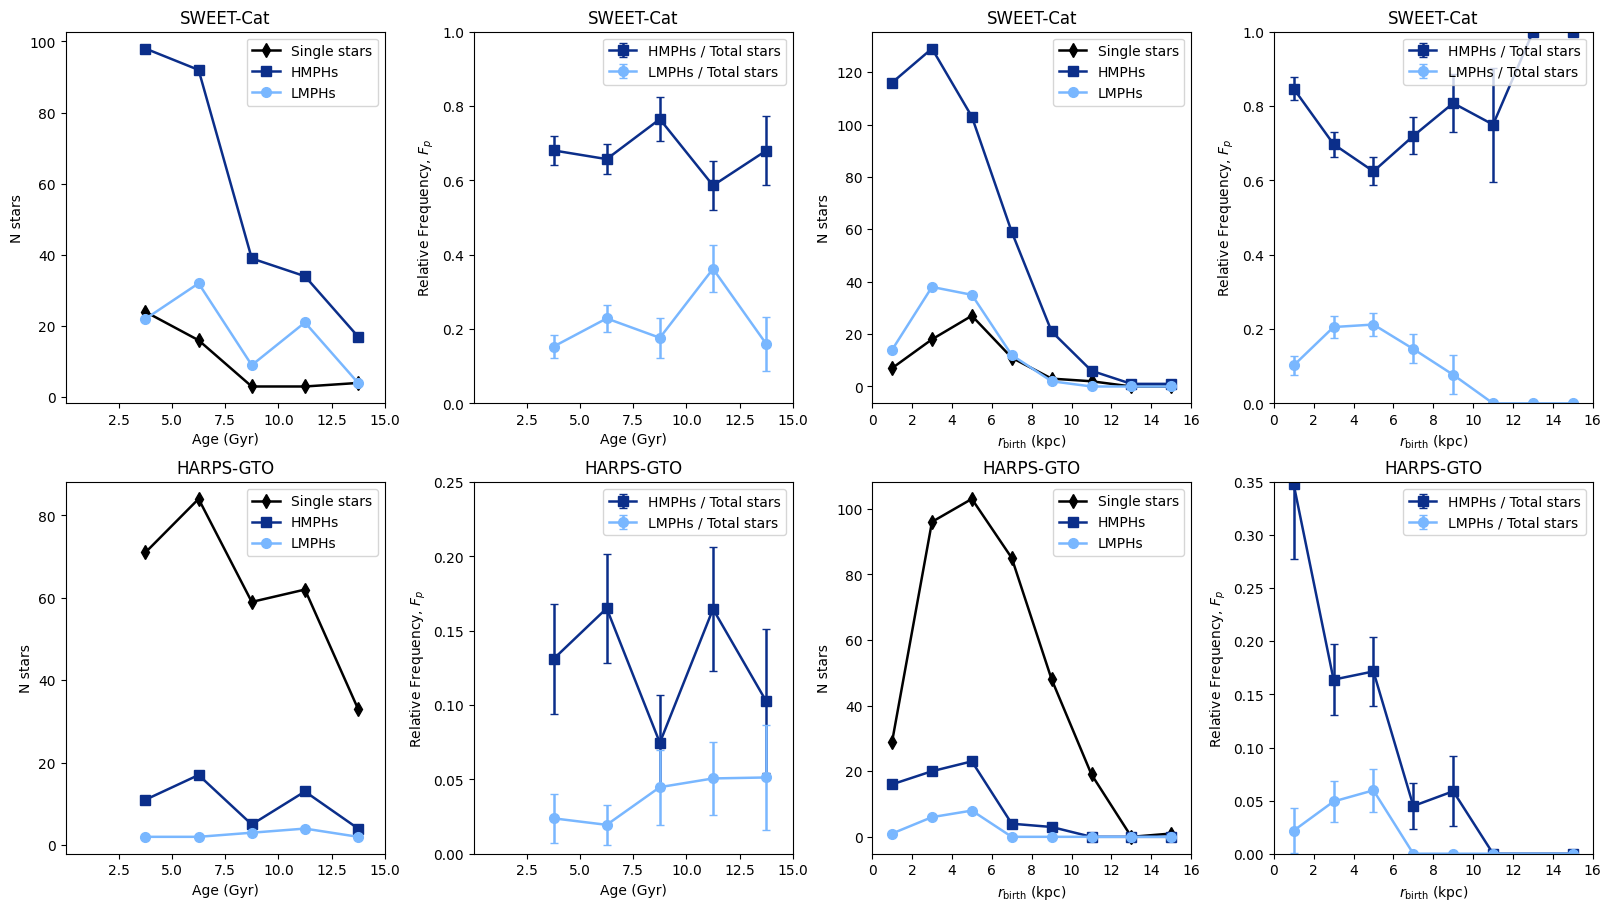

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sweet = pd.read_csv(PROC / "sweetcat_rbirth_gce.csv")
harps = pd.read_csv(PROC / "harps_rbirth_gce.csv")

sweet = sweet[np.isfinite(sweet["age_gyr"]) & np.isfinite(sweet["rbirth_kpc"])].copy()
harps = harps[np.isfinite(harps["age_gyr"]) & np.isfinite(harps["rbirth_kpc"])].copy()

# --- paper-like style ---
COL = {"single":"k", "HMPH":"#0B2E8A", "LMPH":"#79B7FF"}
MRK = {"single":"d", "HMPH":"s", "LMPH":"o"}
LW, MS, CAP = 1.8, 7, 3

def counts_in_bins(df, xcol, bins, cls):
    x = df.loc[df["class"] == cls, xcol].dropna().to_numpy()
    return np.histogram(x, bins=bins)[0]

def frac_and_err(k, n):
    k = np.asarray(k, float)
    n = np.asarray(n, float)
    p = np.full_like(k, np.nan)
    err = np.full_like(k, np.nan)
    m = n > 0
    p[m] = k[m] / n[m]
    err[m] = np.sqrt(np.clip(p[m]*(1-p[m]) / n[m], 0, None))
    return p, err

def plot_block(ax_counts, ax_freq, df, xcol, bins, xcent, xlabel, title,
               freq_ylim=(0,1), mask_bins=None, xlim=None, xticks=None):
    Ns = counts_in_bins(df, xcol, bins, "single")
    Nh = counts_in_bins(df, xcol, bins, "HMPH")
    Nl = counts_in_bins(df, xcol, bins, "LMPH")
    Nt = Ns + Nh + Nl

    if mask_bins is not None:
        Ns, Nh, Nl, Nt = Ns[mask_bins], Nh[mask_bins], Nl[mask_bins], Nt[mask_bins]
        xcent = xcent[mask_bins]

    # counts
    ax_counts.plot(xcent, Ns, marker=MRK["single"], ms=MS, lw=LW, color=COL["single"], label="Single stars")
    ax_counts.plot(xcent, Nh, marker=MRK["HMPH"],   ms=MS, lw=LW, color=COL["HMPH"],   label="HMPHs")
    ax_counts.plot(xcent, Nl, marker=MRK["LMPH"],   ms=MS, lw=LW, color=COL["LMPH"],   label="LMPHs")
    ax_counts.set_title(title)
    ax_counts.set_xlabel(xlabel)
    ax_counts.set_ylabel("N stars")
    ax_counts.legend(loc="upper right", frameon=True)

    # frequency
    ph, eh = frac_and_err(Nh, Nt)
    pl, el = frac_and_err(Nl, Nt)

    m = (Nt > 0) & np.isfinite(ph) & np.isfinite(eh)
    ax_freq.errorbar(xcent[m], ph[m], yerr=eh[m],
                     marker=MRK["HMPH"], ms=MS, lw=LW, capsize=CAP,
                     color=COL["HMPH"], label="HMPHs / Total stars")

    m = (Nt > 0) & np.isfinite(pl) & np.isfinite(el)
    ax_freq.errorbar(xcent[m], pl[m], yerr=el[m],
                     marker=MRK["LMPH"], ms=MS, lw=LW, capsize=CAP,
                     color=COL["LMPH"], label="LMPHs / Total stars")

    ax_freq.set_title(title)
    ax_freq.set_xlabel(xlabel)
    ax_freq.set_ylabel(r"Relative Frequency, $F_p$")
    ax_freq.set_ylim(*freq_ylim)
    ax_freq.legend(loc="upper right", frameon=True)

    if xlim is not None:
        ax_counts.set_xlim(*xlim)
        ax_freq.set_xlim(*xlim)
    if xticks is not None:
        ax_counts.set_xticks(xticks)
        ax_freq.set_xticks(xticks)

# =========================================================
# FIX #2: re-clip rbirth to start at 0 (so HMPHs can pile up near 0 like paper)
# =========================================================
sweet["rbirth_kpc"] = np.clip(sweet["rbirth_kpc"].to_numpy(float), 0.0, 20.0)
harps["rbirth_kpc"] = np.clip(harps["rbirth_kpc"].to_numpy(float), 0.0, 20.0)

# =========================================================
# Binning / ticks like paper
# =========================================================

# Age bins: width 2.5 Gyr (edges), but SHOW starts at 2.5 (we drop first bin 0–2.5)
age_bins = np.arange(0.0, 15.0 + 0.001, 2.5)
age_cent = 0.5*(age_bins[:-1] + age_bins[1:])
mask_age = age_cent >= 2.5

# FIX #1: ticks are BIN EDGES (2.5, 5, 7.5, ...) not centers
age_ticks = age_bins[1:]
age_xlim  = (0.0, 15.0)

# r_birth bins: 0..16 step 2
r_bins  = np.arange(0.0, 16.0 + 0.001, 2.0)
r_cent  = 0.5*(r_bins[:-1] + r_bins[1:])
r_ticks = np.arange(0, 17, 2)
r_xlim  = (0.0, 16.0)

# =========================================================
# Combined Figure_8: 2 rows x 4 cols
# =========================================================
fig = plt.figure(figsize=(16, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

ax = {}
ax["s_age_cnt"] = fig.add_subplot(gs[0,0]); ax["s_age_frq"] = fig.add_subplot(gs[0,1])
ax["h_age_cnt"] = fig.add_subplot(gs[1,0]); ax["h_age_frq"] = fig.add_subplot(gs[1,1])
ax["s_r_cnt"]   = fig.add_subplot(gs[0,2]); ax["s_r_frq"]   = fig.add_subplot(gs[0,3])
ax["h_r_cnt"]   = fig.add_subplot(gs[1,2]); ax["h_r_frq"]   = fig.add_subplot(gs[1,3])

# SWEET
plot_block(ax["s_age_cnt"], ax["s_age_frq"], sweet, "age_gyr",
           age_bins, age_cent, "Age (Gyr)", "SWEET-Cat",
           freq_ylim=(0,1), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks)

plot_block(ax["s_r_cnt"], ax["s_r_frq"], sweet, "rbirth_kpc",
           r_bins, r_cent, r"$r_{\rm birth}$ (kpc)", "SWEET-Cat",
           freq_ylim=(0,1), xlim=r_xlim, xticks=r_ticks)

# HARPS (zoomed frequency axes like paper)
plot_block(ax["h_age_cnt"], ax["h_age_frq"], harps, "age_gyr",
           age_bins, age_cent, "Age (Gyr)", "HARPS-GTO",
           freq_ylim=(0,0.25), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks)

plot_block(ax["h_r_cnt"], ax["h_r_frq"], harps, "rbirth_kpc",
           r_bins, r_cent, r"$r_{\rm birth}$ (kpc)", "HARPS-GTO",
           freq_ylim=(0,0.35), xlim=r_xlim, xticks=r_ticks)

save_fig("Figure_8", fig)
plt.show()

### Figure 9 - HARPS

/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:32: RuntimeWarning: invalid value encountered in divide
  p = np.where(n > 0, k / n, np.nan)
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:34: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + (z**2)/n
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:35: RuntimeWarning: divide by zero encountered in divide
  center = (p + (z**2)/(2*n)) / denom
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:36: RuntimeWarning: divide by zero encountered in divide
  half = (z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom


Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_9.png


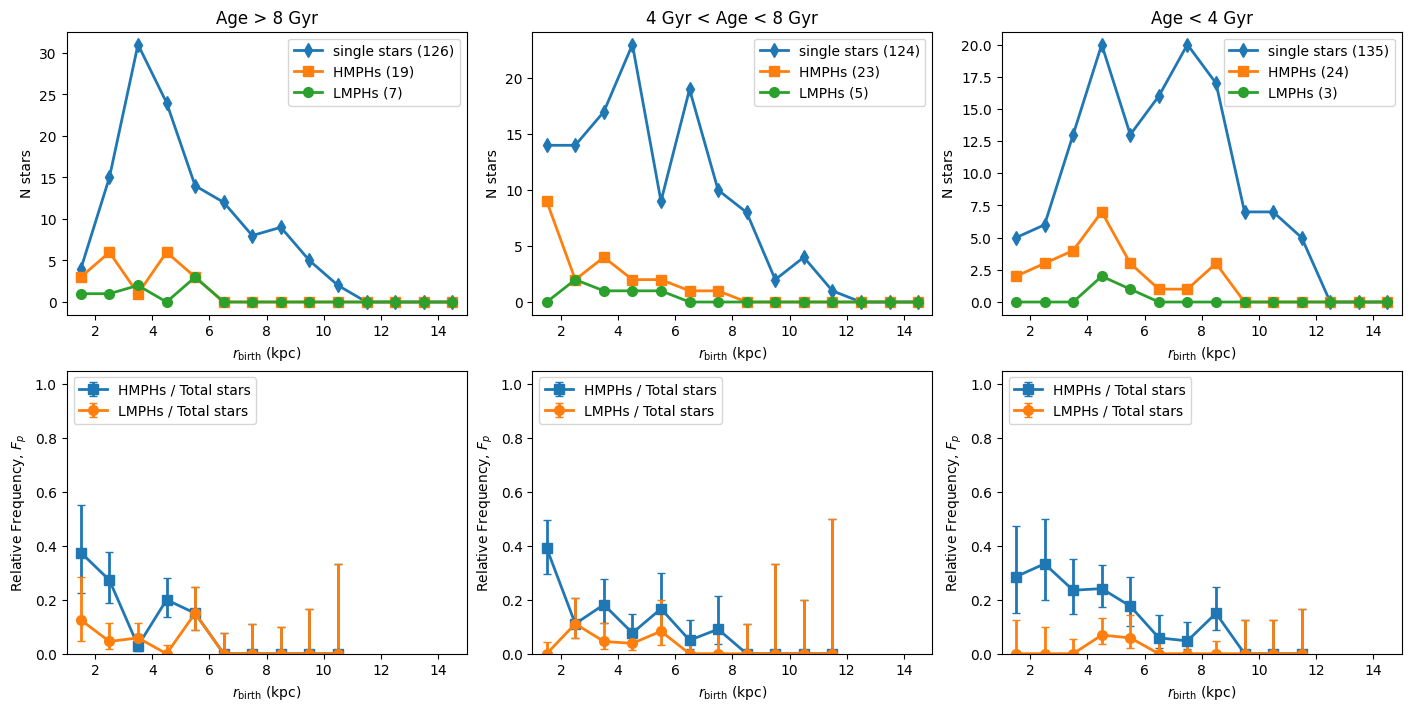

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- load if needed ---
csv_path = PROC / "harps_rbirth_gce.csv"
df = dfh.copy() if "dfh" in globals() else pd.read_csv(csv_path)

# Ensure required cols
need = {"rbirth_kpc","age_gyr","class"}
miss = need - set(df.columns)
if miss:
    raise KeyError(f"Missing columns in HARPS table: {miss}")

# --- paper-like bins ---
age_bins = [(8.0, 13.5), (4.0, 8.0), (0.1, 4.0)]
age_titles = ["Age > 8 Gyr", "4 Gyr < Age < 8 Gyr", "Age < 4 Gyr"]

# Use the paper-like range 1–15 kpc (matches your screenshot better)
rbins = np.arange(1.0, 16.0, 1.0)   # edges: 1..15
rcent = 0.5 * (rbins[:-1] + rbins[1:])

def hist_counts(sub, cls):
    x = sub.loc[sub["class"] == cls, "rbirth_kpc"].dropna().to_numpy()
    return np.histogram(x, bins=rbins)[0]

# --- Wilson score interval (binomial), 68% (~1σ) ---
def wilson_interval(k, n, z=1.0):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    p = np.where(n > 0, k / n, np.nan)

    denom = 1.0 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom

    lo = center - half
    hi = center + half
    return p, lo, hi

fig, axes = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)

for j, (a0, a1) in enumerate(age_bins):
    sub = df[(df["age_gyr"] >= a0) & (df["age_gyr"] < a1)].copy()

    Ns = hist_counts(sub, "single")
    Nh = hist_counts(sub, "HMPH")
    Nl = hist_counts(sub, "LMPH")
    Nt = Ns + Nh + Nl

    # ---------- Top panel: counts ----------
    ax = axes[0, j]
    ax.plot(rcent, Ns, marker="d", markersize=7, linewidth=2, label=f"single stars ({int((sub['class']=='single').sum())})")
    ax.plot(rcent, Nh, marker="s", markersize=7, linewidth=2, label=f"HMPHs ({int((sub['class']=='HMPH').sum())})")
    ax.plot(rcent, Nl, marker="o", markersize=7, linewidth=2, label=f"LMPHs ({int((sub['class']=='LMPH').sum())})")
    ax.set_title(age_titles[j])
    ax.set_xlabel(r"$r_{\rm birth}$ (kpc)")
    ax.set_ylabel("N stars")
    ax.set_xlim(rbins[0], rbins[-1])
    ax.legend(loc="upper right")

    # ---------- Bottom panel: relative frequency with error bars ----------
    ax = axes[1, j]

    # HMPH fraction
    ph, loh, hih = wilson_interval(Nh, Nt, z=1.0)
    # LMPH fraction
    pl, lol, hil = wilson_interval(Nl, Nt, z=1.0)

    # error bars: asymmetric
    eh_low  = ph - loh
    eh_high = hih - ph
    el_low  = pl - lol
    el_high = hil - pl

    ax.errorbar(
        rcent, ph,
        yerr=np.vstack([eh_low, eh_high]),
        marker="s", markersize=7, linewidth=2, capsize=3,
        label="HMPHs / Total stars"
    )
    ax.errorbar(
        rcent, pl,
        yerr=np.vstack([el_low, el_high]),
        marker="o", markersize=7, linewidth=2, capsize=3,
        label="LMPHs / Total stars"
    )

    ax.set_xlabel(r"$r_{\rm birth}$ (kpc)")
    ax.set_ylabel(r"Relative Frequency, $F_p$")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(rbins[0], rbins[-1])
    ax.legend(loc="upper left")

save_fig("Figure_9", fig)
plt.show()

While the qualitative trends agree with the literature, the detailed shape of the distributions differs due to the use of a simplified GCE model and an independent age reconstruction.

## Why exact reproduction is hard

In principle, using the same observational data and the same published methodology should lead to similar results. In practice, however, exact reproduction of published figures is often difficult, even when all major ingredients appear to be available. This is not a failure of the scientific method, but rather a reflection of how complex, data-driven analyses are actually performed. Many intermediate choices — such as quality cuts, binning schemes, acceptable parameter ranges, or the treatment of outliers — are rarely fully documented, yet they can have a noticeable impact on the final visual appearance of the results.

In addition, physically motivated reconstructions (such as stellar ages or Galactic birth radii) rely on models that are themselves approximate and degenerate. Small differences in assumed Galactic chemical evolution, age–metallicity relations, or uncertainty handling can shift stars between bins and subtly reshape distributions, while preserving the underlying physical trends. As a result, independently reconstructed figures may differ in detail, even when they remain fully consistent at a qualitative and interpretative level.

Importantly, the scientific conclusions of such studies are not based on the exact height of individual histogram bins, but on robust, reproducible trends that persist under reasonable variations of the assumptions. Reproducing these qualitative behaviors — rather than pixel-perfect figures — is therefore the correct benchmark for validation. Exact agreement typically requires access to additional, implicit methodological choices or direct communication with the original authors, which reflects standard practice in modern astrophysical research rather than a lack of rigor.